# Esercitazione 11
### Laboratorio di Simulazione Numerica

Questo jupyter notebook contiene l'analisi e i risultati relativi all'esercitazione 11 del corso di LSN. La struttura del notebook è la seguente:

- 11.0 caricamento dei pacchetti utili, preparazione del notebook e introduzione;
- 11.1 come varia la risposta di una rete neurale al variare dei parametri $N_{TRAIN}, \sigma, N_{EPOCHS}$?
- 11.2 fit di un polinomio di grado 3;
- 11.3 fit di una semplice funzione bidimensionale.

--- 

Sconsiglio di ricompilare il jupyter notebook perché alcuni passaggi potrebbero richiedere qualche minuto di tempo.

## 11.0 - Caricamento pacchetti, preparazione del notebook, introduzione

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tqdm import tqdm
import seaborn as sns
import random
import os

sns.set_theme(font_scale=1.7, style='whitegrid')

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, LeakyReLU
from tensorflow.keras.optimizers import Adam, Adadelta, Adagrad, RMSprop
from tensorflow.keras import backend as K
from tensorflow.keras.utils import get_custom_objects

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'    

Con questa esercitazione vogliamo iniziare ad utilizzare e conoscere gli aspetti di base delle reti neurali con architettura _feed-forward_ (letteralmente, "Andare avanti"), nelle quali il flusso di operazioni eseguite dall'algoritmo avviene in una direzione univoca: dallo strato di input verso lo strato di output. Tramite le librerie `Tensorflow` e `Keras` è possibile costruire reti neurali (NN) di questo tipo utilizzando il metodo `Sequential`.

---

Nel discorso che segue ci riferiremo a tecniche di apprendimento automatico supervisionato (_supervised ML_).

---

Una rete neurale consiste in un modello statistico, dunque ha come obiettivo quello di riuscire ad approssimare la relazione vera, se esiste, che intercorre tra una variabile di input $x_i$ e la corrispettiva variabile di output $y_i$, che indicherò con il pedice _true_: $$y_{true,i}=f(x_i).$$
In quanto modello statistico, una rete neurale dipende da un certo vettore di parametri $\vec{\theta}$ e, fissato $\vec{\theta}$, può fornire una stima teorica di $y_i$ secondo una relazione del tipo: $$y_{teo,i} = \hat{f}(x_i|\vec{\theta}),$$ dove ho voluto indicare con il cappuccio il fatto che il modello rimane un'approssimazione della legge vera che può esistere tra le due variabili. La stima proposta dalla rete può essere migliorata tramite una fase di addestramento, durante la quale la rete impara ad avvicinare il valore di $y_{teo,i}$ alle misure registrate per la stessa variabile $y_{meas,i}$ che, in quanto tali, sono rappresentative della relazione vera che intercorre tra $x$ e $y$ al netto di un errore di misura intriseco, che chiamerò $\sigma_i$.

Se assumiamo adesso di avere a disposizione un numero $N$ di coppie di variabili $(x_i, y_{meas,i})$, è utile suddividere questo insieme in due parti, costruendo i campioni di training e di test/validazione; il primo è utile per addestrare la rete e le viene fornito in modo che possa riconoscere il pattern da riprodurre nel modello (è il campione sul quale la rete ottimizza la sua ricerca in fase di addestramento), il secondo è importante per verificare le performance della rete su un campione diverso, in modo tale da interrompere l'addestramento quando si inizia a registrare il fenomeno dell'_overtraining_ (ci permette di tenere sotto controllo l'addestramento).

Come già detto, una rete neurale è un modello statistico che contiene un certo numero di parametri. La procedura di addestramento della rete consiste nel cercare la configurazioni di parametri che meglio approssima la funzione vera, che assumiamo essere rappresentata (a meno di errori intrinseci) dal campione di training; in altre parole, si tratta di una discesa verso il minimo assoluto di una funzione di costo all'interno dello spazio dei parametri.

Per ottimizzare la rete è necessario infatti definire una funzione di costo $L(y_{meas}, y_{teo})$ che deve essere minimizzata. Esistono svariate tecniche di minizzazione, alcune più _greedy_, altre pensate per evitare che la ricerca ristagni in un minimo locale nello spazio dei parametri. Ne vedremo alcune più avanti.

## 11.1 - Analisi dei alcuni dei parametri di architettura di una rete

Oltre ai parametri interni alla rete (pesi delle connessioni tra i nodi, bias, ecc), è necessario stabilire il valore di altri parametri più generali, che ci permettono di definire il processo di addestramento. In questo esercizio vogliamo studiare come varia la risposta della stessa rete neurale (teniamo fissati i parametri interni, quindi il numero di nodi, il numero di connessioni, eccetera) al variare di:
1. errore sulle misure, $\sigma$;
2. dimensione del campione di training a cardinalità fissata del campione di test;
3. numero di epoche di addestramento.

Facciamo questo studio sottoponendo alla rete dati di input e output monodimensionali legati da una relazione polinomiale di grado uno: $y = mx+b$.

La rete che ho scelto di analizzare è identica a quella fornita nella consegna dell'esercizio: un layer nascosto, ottimizzatore SGD, funzione di costo MSE.

In [1]:
# valori fissati per m e b
m = 2 
b = 1 

Per analizzare le performance della rete al variare dei parametri di interesse ho deciso di procedere nel modo seguente:
1. ho definito tre vettori di dimensione cinque, contenenti cinque valori diversi dei parametri in esame;
2. ho implementato tre cicli for annidati, così da ottimizzare un totale di 125 reti neurali identiche nella loro architettura ma tutte diverse nella scelta dei tre parametri di riferimento;
3. ho salvato l'ultimo valore ottenuto della metrica (funzione che quantifica la bontà di un modello nella stima degli output associati ad un certo campione) valutata sul campione di test. Ho fatto questa scelta perché analizzare il valore della stessa funzione calcolato usando il campione di training potrebbe risultare fuorviante (essendo in tal caso un valore potenzialmente soggetto all'overfitting).

In [6]:
sigma   = [0.2, 0.4, 0.6, 0.8, 1.0]
Nepochs = [2, 10, 20, 50, 100]
Ntrain  = [50, 100, 500, 1000, 2000]

In [ ]:
#Per ora non si vedono i log di keras perché ho commentato e scommentato la cella
#Se li avessi lasciati ci sarebbero state numerose righe di output

train_loss = np.zeros((5, 5))
test_loss  = np.zeros((5, 5))

for epoc in Nepochs:
    print("25 run per esplorare il caso Nepochs=", epoc)
    for i in tqdm(range(5)):
        for j in range(5):
            x_train = np.random.uniform(-1, 1, Ntrain[i])
            x_valid = np.random.uniform(-1, 1, 50)
            x_valid.sort()
            y_target = m * x_valid + b 

            sig = 0.2*j

            y_train = np.random.normal(m * x_train + b, sig) 
            y_valid = np.random.normal(m * x_valid + b, sig)
            
            # per ricominciare da capo il training ogni volta devo definire da zero la rete
            # così posso vedere il risultato ottenuto con numeri variabili di epoche
            # il primo ciclo è sulle epoche, il secondo su Ntrain, il terzo sulla sigma 
            # sto allenando un totale di 225 reti diverse
            
            model = tf.keras.Sequential()
            model.add(Dense(1, input_shape=(1,)))
            model.compile(optimizer='sgd', loss='mse', metrics=['mse'])

            history = model.fit(x=x_train, y=y_train, 
                  batch_size=32, epochs=epoc,
                  shuffle=True, 
                  validation_data=(x_valid, y_valid), verbose=0)

            train_loss[i][j] = history.history['mse'][epoc-1]
            test_loss[i][j]  = history.history['val_mse'][epoc-1]
            
    fig, ax = plt.subplots(figsize = (10, 8))
    sns.heatmap(test_loss, annot=True, ax=ax, cmap="coolwarm", xticklabels=sigma, 
                    vmin=0, vmax=1, yticklabels=Ntrain)
    ax.set_title("Test MSE al variare di $\sigma$ e $N_{TRAIN}$, caso "+str(epoc)+" epoche")
    ax.set_ylabel("$N_{train}$")
    ax.set_xlabel("$\sigma$")
    plt.savefig("Results/heatmap_"+str(epoc)+".png")
    plt.show(False)

<img src="test_heatmap.gif">


__Figura 1:__ l'animazione mostra una griglia 5x5 contenente i valori di MSE calcolati sul campione di test al variare di $\sigma$ e $N_{TRAIN}$. Ogni immagine che compone l'animazione è inoltre corrispondente ad una determinata scelta di epoche, i cui valori sono resi espliciti nel titolo delle immagini e nei vettori definiti qualche cella fa. Dai risultati ottenuti si capisce che:

- __sigma:__ all'aumentare del valore di sigma, cioè delle incertezze con cui vengono forniti i valori target di output, le reti forniscono dei risultati più imprecisi. Quando si addestrano dei modelli su insiemi complessi e soggetti a grandi errori è utile prevedere tempi di allenamento più lunghi, aumentare il numero di dati a disposizione (cercando altri dati oppure operando qualche tecnica di data augmentation);
- __set di training:__ dall'analisi dei valori che ho assunto per $N_{TRAIN}$ risulta evidente che con l'aumentare dei dati a disposizione diminuisce l'errore commesso dalla rete neurale. Sicuramente questo è un aspetto molto importante, infatti questi modelli che si basano su un periodo di addestramento diventano sempre più utili e precisi al crescere della ricchezza del campione. Mi sento però di sottolineare un aspetto: in questa sede mi sono occupato dello studio di $N_{TRAIN}$ mantenendo invariato il valore di $N_{TEST}$. Se, da un lato, l'aumento della cardinalità del campione su cui effettuiamo il training è un bene, dall'altro è importante fornire all'algoritmo un campione sufficientemente grande per poter valutare la bontà delle precisioni su dati neutrali, quelli di test appunto. Rimane buona prassi mantenere un rapporto di circa 80%-20% tra set di training e set di test. Una seppur debole prova (non ritengo queste casistiche sufficienti a spiegare il fenomeno) di quanto detto potrebbe essere rappresentata dal fatto che la grande differenza di precisione raggiunta utilizzando set di training di dimensione diversa diventa sempre meno importante con l'aumentare delle epoche. Nell'immagine corrispondente all'epoca 100, per esempio, il valore di MSE registrato per i set di training di dimensione $N_{TRAIN}=500,1000,2000$ (sto considerando il caso soggetto all'errore più piccolo: $\sigma=0.2$) è dello stesso ordine di grandezza;
- __epoche:__ aumentando il numero di epoche prolunghiamo i tempi di addestramento del modello, eseguendo una ricerca del minimo più insistente nello spazio dei parametri. Tramite l'animazione vediamo che in generale è vero che all'aumentare del numero di epoche migliorano le performance del modello. Se però andiamo a vedere i grafici delle funzioni di costo in funzione delle epoche (non sono riportati in questo esercizio ma possiamo vederli, per esempio, in relazione alla consegna 11.2), notiamo che, tipicamente, dopo una primo momento di netto miglioramento delle performance, le reti neurali sembrano raggiungere una seconda fase di discesa più lenta, a volte un andamento stazionario. Capita anche di registrare casi in cui la funzione di costo valutata sul set di test ricomincia a salire oltre una certa epoca. Stiamo in tal caso assistendo all'overfitting: il modello sta iniziando ad imitare le fluttuazioni statistiche del set di training, diventando in questo modo inefficace nell'analisi di dati nuovi, come quelli di test. In sistemi lineari come quello analizzato in questo primo esercizio è difficile che succeda qualcosa del genere, specialmente utilizzando una rete neurale che presenta due soli parametri: peso e bias. Però, come vedremo, all'aumentare del numero di parametri, le reti avranno anche la tendenza a over-fittare i dati di training.


__Commento conclusivo:__ ho deciso di presentare i dati con questa animazione per non ripetere la modalità di controllo che effettuerò nel prossimo esercizio (rappresentazione degli output target messi a confronto con quelli previsti dalle mie reti). Ho comunque, durante lo svolgimento dell'esercitazione, controllato in modo casuale alcuni dei risultati ottenuti e confermano quanto sottolineato nel commento della Figura 1: per allenare in modo intelligente una rete neurale occorre bilanciare il numero di dati che compongono i set di training e test ed effettuare un numero di epoche sufficientemente lungo da permettere al modello di imparare il più possibile, fermando l'addestramento quando la funzione di costo valutata sul set di test inizia ad aumentare il proprio valore.

## 11.2 - Fit di un polinomio di terzo grado

In questa seconda parte dell'esercizio vogliamo affrontare un problema lievemente più complesso, ovvero il fit della funzione: $f(f)= 4-3x-2x^2+3x^3$.

---

Nel farlo, vogliamo analizzare come le scelte riguardanti l'architettura e l'ottimizzazione della NN possono influire sui risultati. Per far questo ho deciso di definire alcune liste, nelle quali ho raccolto una serie di scelte possibili nella costruzione di una rete. Analizzerò in questo modo diversi ottimizzatori, numero di layer nascosti, nodi per layer nascosto e funzioni di attivazione.

Volendo mettere a confronto tutti e tre gli ottimizzatori proposti ho deciso di allenare tre reti, ognuna delle quali viene compilata tramite uno dei tre ottimizzatori. I restanti parametri sono invece scelti in modo casuale dalle liste raccolte nella cella seguente.

Inizialmente ho fatto uno studio più sistematico dei vari parametri: ho messo alla prova le funzioni di attivazione nei layers esterni e interni, modificato il numero di nodi e il numero di strati nascosti in modo consistente. Quello che propongo in questa sede è in parte già il risultato della mia selezione (non sto proponendo funzioni di attivazione lineare per gli strati interni, o metodi di ottimizzazione come `Adagrad` e `Adadelta`, che ho comunque testato in precedenza). Ho voluto lasciare la presentazione in questa forma per sottolineare l'importanza nel ML di una prima fase di ricerca degli strumenti più adatti al problema.

In [3]:
# qualche scelta possibile 

optimizators = ['rmsProp', 'Adam', 'SGD'] 
layers = [1, 2, 3, 4]
nodes =  [3, 8, 16, 32]
actif =  ['relu', 'selu', 'elu', 'tanh']

Ho inoltre definito una funzione, `spawn_DNN(times, opt, nodes, actf)`, tramite cui è possibile costruire una rete che si adegua alle scelte effettuate: essa aggiunge al modello `Sequential` un primo layer di tipo `Dense` contenente 16 nodi e per cui ho scelto di applicare una funzione di attivazione lineare. A seguire sono disposti `times` layer di tipo `Dense`, contenenti `nodes` nodi nascosti; per questi layers la funzione di attivazione è di tipo `actf`. Infine, il modello è compilato utilizzando un ottimizzatore di tipo `opt`.

In [9]:
def spawn_DNN(times, opt, nodes, actf):
    model = tf.keras.Sequential()
    model.add(Dense(units=16, input_shape=(1,), activation='linear'))
    
    for i in range(times):
        model.add(Dense(units=nodes, activation=actf))
        
    model.add(Dense(units=1, activation='linear'))
    model.compile(optimizer=opt, loss='mse', metrics=['mse'])
    
    return model

In [10]:
def f(x):
    return 4 - 3*x - 2*x**2 + 3*x**3

In [11]:
x_train = np.random.uniform(-1,1,10000)
x_test  = np.random.uniform(-1,1,1200)

y_target  = f(x_test)

y_train = np.random.normal(f(x_train), 0.05)
y_test  = np.random.normal(f(x_test), 0.05)

In [12]:
#alcune strutture dati utili
train_loss = []
test_loss  = []
train_acc  = []
test_acc   = []
labels     = [] 

Nella cella seguente è implementata la strategia che ho spiegato in precedenza: la funzione `random.choice(list)` mi permette di selezionare casualmente il numero di layers nascosti, il numero di nodi presenti in questi strati e il tipo di funzione di attivazione che presentano.

In [13]:
os.system('rm Results/*.h5')               # rimuovo i pesi salvati dalla vecchia run

x_new = np.random.uniform(-1.5,1.5,500)    # li userò per fare un grafico dei risultati
pred  = []                                 # le cui ordinate verranno salvate qui

for i in range(3):
    opt = optimizators[i]
    lay = random.choice(layers)
    nod = random.choice(nodes)
    act = random.choice(actif)
    
    labels.append('DNN('+str(opt)+", "+str(lay)+", "+str(nod)+", "+str(act)+")")   # label della rete
    
    print('Running 20 epochs for training a '+str(labels[i]))
    newmodel = spawn_DNN(lay, opt, nod, act)                                       # genero la rete
    
    hist = newmodel.fit(x=x_train, y=y_train,                                      # la alleno
              batch_size=20, epochs=15, 
              validation_data=(x_test, y_test), verbose=0)
    
    pred.append(newmodel.predict(x_new))                                           # salvo le fz. di costo
                                                                                   # e i valori delle metriche
    train_loss.append(hist.history['loss'])                                        
    test_loss.append(hist.history['val_loss'])
    train_acc.append(hist.history['mse'])
    test_acc.append(hist.history['val_mse'])
    
    newmodel.save_weights('Results/pesi_'+labels[i]+'.h5')                         # salvo i pesi delle tre reti

rm: cannot remove 'Results/*.h5': No such file or directory


Running 20 epochs for training a DNN(rmsProp, 1, 32, selu)
Running 20 epochs for training a DNN(Adam, 4, 3, relu)
Running 20 epochs for training a DNN(SGD, 4, 16, elu)


### Mettiamo a confronto le prestazioni

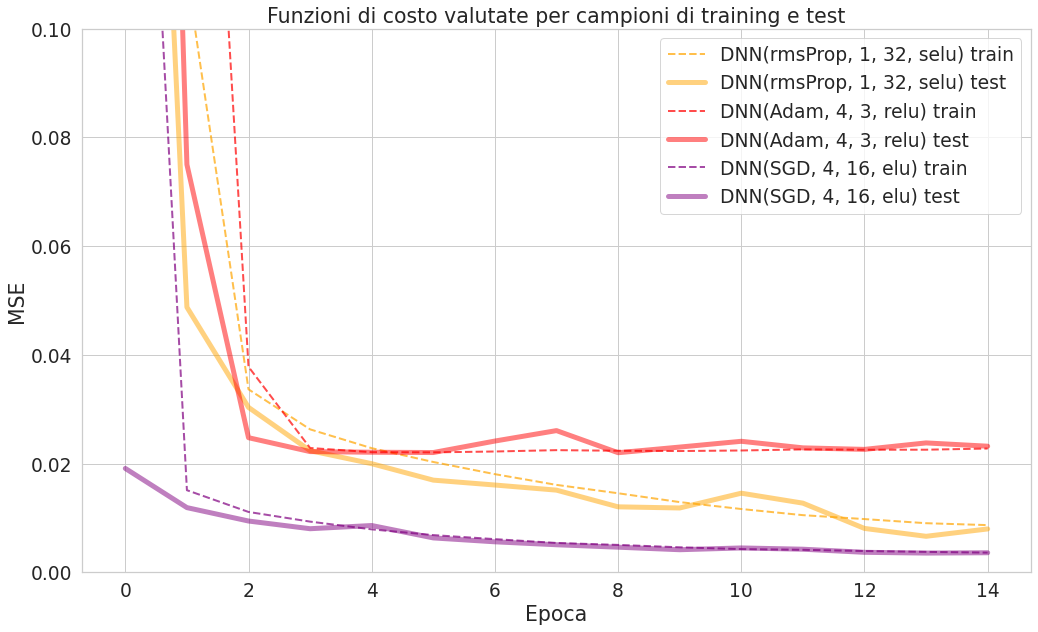

In [22]:
colors = ['orange', 'red', 'purple', 'blue']

fig, ax = plt.subplots(figsize=[17, 10])
plt.title('Funzioni di costo valutate per campioni di training e test')
plt.xlabel('Epoca')
plt.ylabel('MSE')
plt.ylim(0, 0.1)

for i in range(3):
    ax.plot(train_loss[i], color=colors[i], alpha=0.7, label=labels[i]+' train',
             linewidth=2, linestyle='--')
    ax.plot(test_loss[i], color=colors[i], alpha=0.5, label=labels[i]+ ' test',
             linewidth=5, linestyle='-')

ax.legend()
plt.show()

__Figura 2:__ in figura sono raffigurati gli andamenti delle funzioni di costo valutate sui set di training (linee sottili tratteggiate) e sul set di test (linee spesse e continue). Per semplicità, sono riprodotti i risultati di sole tre combinazioni dei parametri che ho studiato. I parametri sono resi espliciti nelle stringhe identificative dei vari modelli. Riporto di seguito alcuni commenti per completare il discorso.

- a prescindere dal numero di nodi o strati nascosti, __ottimizzatori diversi__ permettono di raggiungere risultati molto differenti in termini di addestramento. Nella figura 2 vediamo come la funzione di costo valutata sul set di test durante un addestramento operato tramite `rmsProp` siamo molto meno liscia di quelle corrispondenti ad altri ottimizzatori. Questo fenomeno si ripropone anche in altre combinazioni di parametri. Ancora, utilizzando altri ottimizzatori (come `Adagrad`, che non ho poi riportato nella relazione) notiamo che se alcuni ci permettono di ottenere una discesa regolare del valore della funzione di costo, con altri questo non risulta possibile, ottenendo curve che si assestano su valori maggiori di MSE. In misura minore di quanto accade con `Adagrad` e `Adadelta` possiamo comunque vedere questo comportamento nella Figura 2;
- il __numero di  neuroni__ e di __strati nascosti__ contribuisce in modo molto rilevante alla capacità di una rete di adattarsi ai dati di trainig. Nel corso dell'analisi mi è capitato più volte di costruire reti composte da pochi layers (uno o due) e pochi neuroni. In quesi casi, seppure la funzione di costo mostrava il miglioramento delle performance in funzione delle epoche, i modelli non erano in grado di seguire con precisione l'andamento della funzione target, indipendentemente dall'ottimizzatore scelto; 
- le previsioni delle reti __fuori dal range__ di interesse spesso mostrano l'incapacità dei modelli di generalizzare il problema. Tipicamente i risultati migliori li ho ottenuti utilizzando l'ottimizzatore `Adam`, con cui le reti raggiungono configurazioni in grado di effettuare previsioni più in linea con l'andamento di $f(x)$. In ogni caso, per avere risultati apprezzabili è necessario inizializzare modelli con numeri maggiori di neuroni e strati nascosti.
- la scelta della __funzione di attivazione__ nei layer è cruciale: in un problema come questo ho notato che la scelta migliore consiste nello scegliere una funzione di attivazione lineare per gli strati di ingresso e di uscita ma adottarne altre come funzioni di attivazione negli strati interni. Proprio per questo ho predisposto la selezione casuale all'inizio del programma permettendo di scegliere tra `relu, selu, elu, tanh`.

### Previsioni delle reti fuori dal range [-1,1]

In [15]:
y_tru = f(x_new)

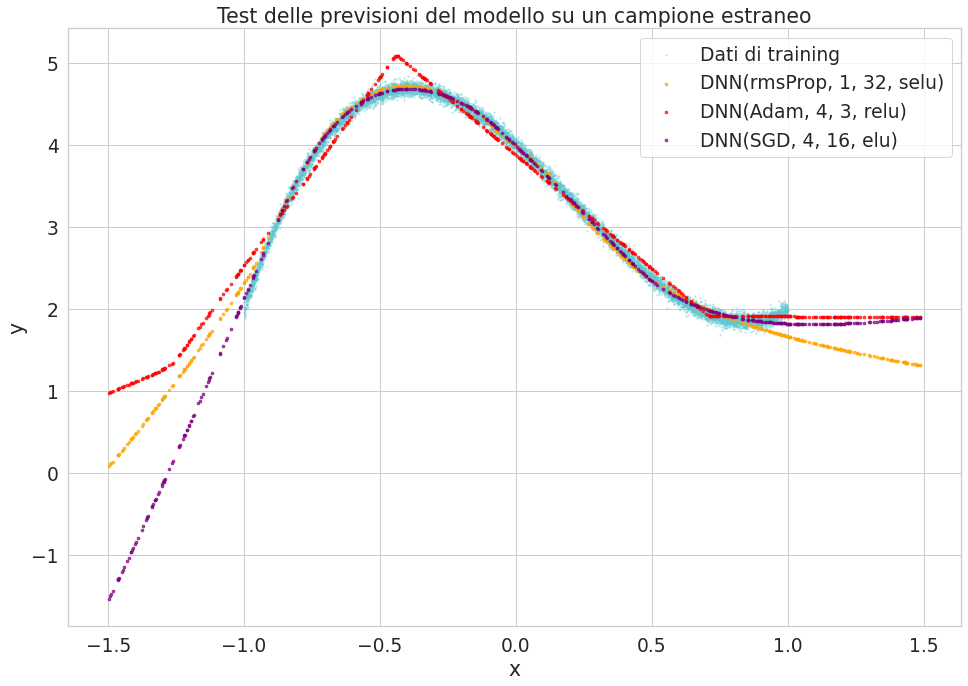

In [17]:
plt.figure(figsize=(16,11))
plt.title('Test delle previsioni del modello su un campione estraneo')

plt.scatter(x_train, y_train, alpha= 0.3, label='Dati di training', marker='.', s=8, color='#5cc7d1')
for i in range(3):
    plt.scatter(x_new, pred[i], color=colors[i], alpha=0.7, label=labels[i], s=7)
plt.ylabel('y')
plt.xlabel('x')
plt.legend()
plt.show()

__Figura 3:__ i modelli rappresentati in figura presentano alcune differenze. Nel corso dello svolgimento dell'esercitazione 11 ho confrontato numerose combinazioni di parametri, rendendomi conto che alcune funzioni di attivazione (ad esempio `linear`) non permettono di ottenere performance apprezzabili. Al contrario, funzioni di attivazione differenti (più in linea con una logica di non-linearità) come `elu, relu, selu, tanh` permettono di ottenere performance migliori anche utilizzando un numero inferiore di neuroni. In questo caso possiamo notare come il modello in cui ho predisposto numeri maggiori di neuroni e strati interni (`SGD`, viola) permetta di seguire in modo più preciso l'andamento dei punti che compongono il set di training e che ho rappresentato in azzurro. Ritengo anche interessante notare che un ottimizzatore che fornisce tipicamente performance molto buone come `Adam`, se inserito in un'architettura inadatta (molti strati e pochi neuroni per strato) non è in grado di condurre la rete ad un addestramento soddisfacente.  

__Commento conclusivo:__ al termine di questo secondo esercizio mi sento di dire che esiste una parte cruciale nell'approccio ad un problema di fit tramite il ML che corrisponde alla selezione degli strumenti che si intende utilizzare. A volte si può essere tentati dal rendere più complesso il proprio modello, ottenendo uno strumento molto elastico e capace di adattarsi perfettamente ad ogni sistema si analizzi. Questa tentazione deve essere sempre soppesata da una piena valutazione dei costi dell'addestramento e da una ricerca accurata per comprendere se esistono strumenti che ci permettono di raggiungere gli stessi risultati impegnando meno energie in termini di tempo e memoria.

## 11.3 - Fit di una funzione bidimensionale

Infine ci siamo occupati dell'utilizzo di una rete neurale per fittare la funzione bidimensionale:

$$ f(x,y)=\sin (x^2+y^2), \qquad \text{con}\qquad x\in\biggl[-\frac{3}{2}, \frac{3}{2}\biggr],\,\,y\in  \biggl[-\frac{3}{2}, \frac{3}{2}\biggr].$$

A tal fine ho costruito la rete seguente, nella quale implemento le scelte che sono risultate più efficaci nell'esercizio 11.2:

In [18]:
model3 = tf.keras.Sequential()
model3.add(Dense(units=16, input_shape=(2,), activation='linear'))   #attivazione iniziale lineare
model3.add(Dense(units=32, activation='selu'))                       #interna selu
model3.add(Dense(units=32, activation='elu'))                        #ed elu
model3.add(Dense(units=1, activation='linear'))                      #attivazione finale lineare
model3.compile(optimizer='adam', loss='mse', metrics=['mse'])
model3.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_19 (Dense)             (None, 16)                48        
_________________________________________________________________
dense_20 (Dense)             (None, 32)                544       
_________________________________________________________________
dense_21 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_22 (Dense)             (None, 1)                 33        
Total params: 1,681
Trainable params: 1,681
Non-trainable params: 0
_________________________________________________________________


In [19]:
def g(x,y):
    return np.sin(x**2+y**2)


np.random.seed(0)

x_train = np.zeros((10000, 2))
x_train[:,0] = np.random.uniform(-1.5, 1.5, 10000)
x_train[:,1] = np.random.uniform(-1.5, 1.5, 10000)

x_new = np.zeros((5000, 2))
x_new[:,0] = np.random.uniform(-1.5, 1.5, 5000)
x_new[:,1] = np.random.uniform(-1.5, 1.5, 5000)

x_valid = np.zeros((1500,2))
x_valid[:,0] = np.random.uniform(-1.5, 1.5, 1500)
x_valid[:,1] = np.random.uniform(-1.5, 1.5, 1500)

et = np.sin(x_valid[:,0]**2 + x_valid[:,1]**2)

sigma = 0.01
z_train = np.random.normal(np.sin(x_train[:,0]**2 + x_train[:,1]**2), sigma) 
z_valid = np.random.normal(np.sin(x_valid[:,0]**2 + x_valid[:,1]**2), sigma)

In [20]:
# anche in questa cella ho cancellato i log di keras

hist3 = model3.fit(x=x_train, y=z_train, 
              batch_size=32, epochs=40, 
              validation_data=(x_valid, z_valid), shuffle=True, verbose=0)

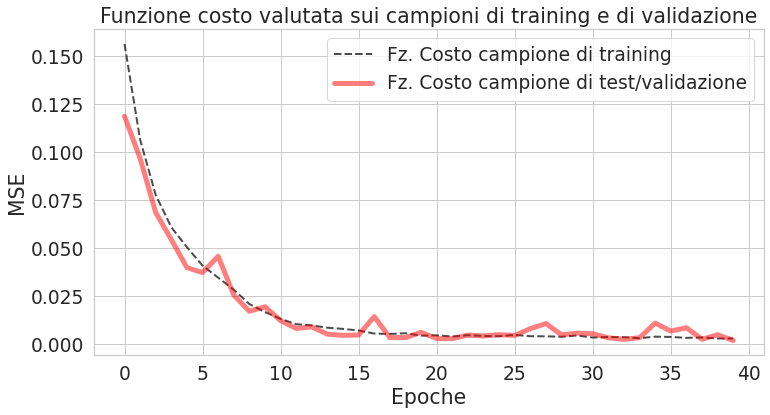

In [21]:
plt.figure(figsize=(12,6))
plt.title('Funzione costo valutata sui campioni di training e di validazione')
plt.plot(hist3.history['loss'], linewidth=2, linestyle='--', alpha=0.7, color='black', label='Fz. Costo campione di training')
plt.plot(hist3.history['val_loss'], linewidth=5, linestyle='-', alpha=0.5, color='red', label='Fz. Costo campione di test/validazione')
plt.ylabel('MSE')
plt.xlabel('Epoche')
plt.legend()
plt.show()

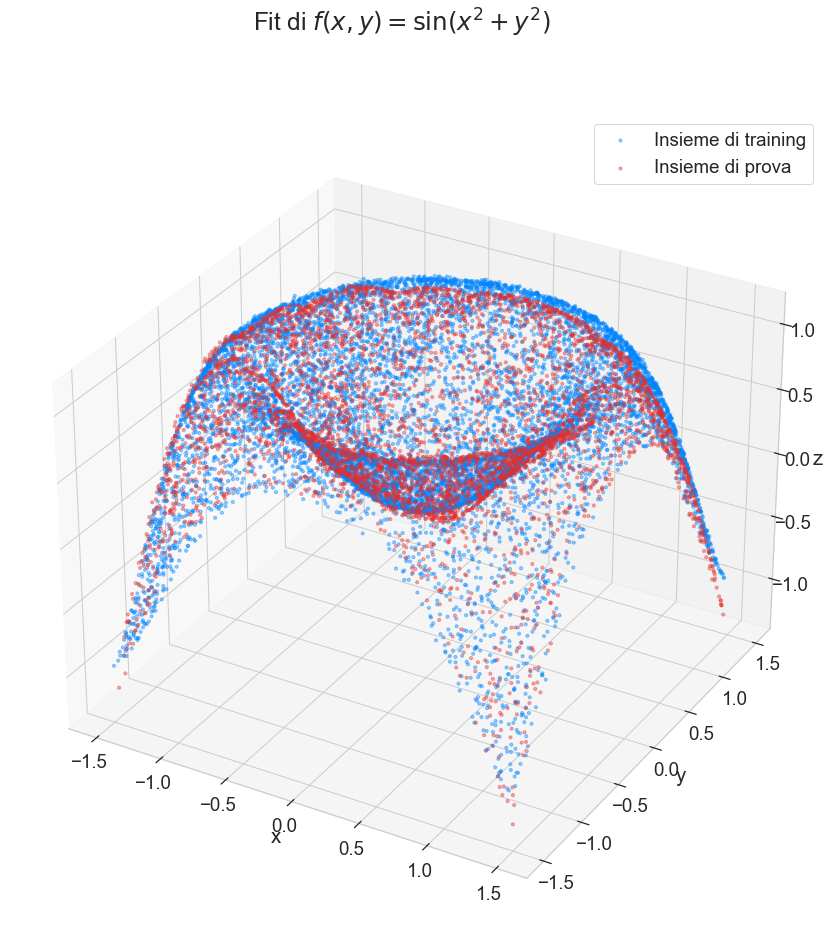

In [60]:
from mpl_toolkits import mplot3d

fig = plt.figure(figsize=(15,15))
ax = plt.axes(projection='3d')
plt.suptitle(r"Fit di $ f(x,y)=\sin (x^2+y^2)$")

ax.scatter3D(x_train[:,0], x_train[:,1], z_train, color='#0085ff', alpha=0.4, s = 10, label='Insieme di training')
ax.scatter3D(x_new[:,0], x_new[:,1], model3.predict(x_new), color='#e33030', alpha=0.4, s = 10, label='Insieme di prova')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.legend()
plt.show()

__Figure 4,5:__ i due grafici mostrano che il modello è in grado di produrre delle previsioni su nuovi dati che sono in linea con la forma della $f(x,y)$.